In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

plt.style.use(['grid', 'notebook'])

In [ ]:
#class - sheetpileC for sheetpile (clay)
class SheetPileC:
    def __init__(self, properties):

        #initializing the properties
        self.phi = properties['phi']
        self.gamma_unsat = properties['gamma_unsat']
        self.gamma_sat = properties['gamma_sat']
        self.cohesion = properties['C']
        self.sigma_all = properties['sigma_all']

        #given lengths
        self.L1 = properties['L1']
        self.L2 = properties['L2']

        #intermediate results
        self.ka = None
        self.sigma_1_dash = None
        self.sigma_2_dash = None
        self.P1 = None
        self.z1_bar = None
        self.D = None
        self.L4 = None
        self.L3 = None
        self.sigma_6 = None
        self.sigma_7 = None
        self.Mmax = None
        self.S = None

    #ka for granular soil
    def earth_pressure_active(self):
        phi_rad = self.phi * (np.pi/ 180)
        self.ka = (1-np.sin(phi_rad))/(1+np.sin(phi_rad))
        return self.ka
    
    def sigma_1_eff(self): #gamma_unsat is the unit weight of soil above the water table, L1 is given
        self.sigma_1_dash = self.gamma_unsat * self.L1 * self.ka
        return self.sigma_1_dash
    
    #func 3 = sigma2-dash calculation aka the effective stress just below the water table but above the dredge line
    def sigma_2_eff(self):
        self.gamma_eff = self.gamma_sat - 9.810
        self.sigma_2_dash = self.sigma_1_dash + self.gamma_eff * self.L2 * self.ka
        return self.sigma_2_dash
    
    #P1 calculation
    def P1_calc(self):
        self.p1 = 0.5 * self.L1 * self.sigma_1_dash #upper triangle
        self.p2 = self.L2 * self.sigma_1_dash #lower rectangle
        self.p3 = 0.5 * self.L2 * (self.sigma_2_dash - self.sigma_1_dash) #lower triangle
        self.P1 = self.p1 + self.p2 + self.p3
        return self.P1
    
    #z1_bar calculator
    def z1barcalc(self):
        z1 = self.L2 + (self.L1/3)
        z2 = self.L2/2
        z3 = self.L2 / 3

        self.z1_bar = (1/self.P1) * (self.p1 * z1 + self.p2 * z2 + self.p3 * z3 ) 
        return self.z1_bar
    
    #theoretical D calculation
    def theoretical_D(self):
        c1 = 4 * self.cohesion - (self.gamma_unsat * self.L1 + self.gamma_eff * self.L2)
        c2 = -1 * 2 * self.P1
        c3 = ((self.P1 *(self.P1 + (12 * self.cohesion * self.z1_bar)))/((self.gamma_unsat * self.L1 + self.gamma_eff * self.L2) + 2 * self.cohesion)) * -1

        coeff = (c1, c2, c3)
        root = np.roots(coeff)

        for r in root:
            if np.isreal(r) and r>0:
                self.D = np.real(r)
                break
        
        return self.D
    
    #sigma_6_calculation
    def sigma_6_calc(self):
        self.k = self.gamma_unsat * self.L1 + self.gamma_eff * self.L2
        self.sigma_6 = 4 * self.cohesion - self.k
        return self.sigma_6
    
    #sigma_7_calculation
    def sigma_7_calc(self):
        self.sigma_7 = 4 * self.cohesion + self.k
        return self.sigma_7
    
    #L4 calculation
    def L4_calc(self):
        self.L4 = (self.D * (4 * self.cohesion - self.k) - self.P1) / (4 * self.cohesion)
        return self.L4
    
    #L3 calculation
    def L3_calc(self):
        self.L3 = self.D - self.L4
        return self.L3
  
    def pressure_draw(self):
        self.earth_pressure_active()
        print(f'ka = {self.ka}')

        self.sigma_1_eff()
        print(f'sigma_1_dash = {self.sigma_1_dash} kPa/m')

        self.sigma_2_eff()
        print(f'sigma_2_dash = {self.sigma_2_dash} kPa/m')

        self.P1_calc()
        print(f'P1 = {self.P1} kN/m')

        self.z1barcalc()
        print(f'z1_bar = {self.z1_bar} m')

        self.theoretical_D()
        print(f'D = {self.D} m')

        self.sigma_6_calc()
        print(f'sigma_6 = {self.sigma_6} kPa/m')

        self.sigma_7_calc()
        print(f'sigma_7 = {self.sigma_7}')

        self.L4_calc()
        print(f'L4 = {self.L4} m')

        self.L3_calc()
        print(f'L3 = {self.L3} m')

        depths = [0,
                   -1 * self.L1, 
                   -1 * (self.L1 + self.L2), 
                   -1 * (self.L1 + self.L2), 
                   -1 * (self.L1 + self.L2 + self.L3), 
                   -1 * (self.L1 + self.L2 + self.D),
                   -1 * (self.L1 + self.L2 + self.D)
                   ]
        stresses = [0, 
                    self.sigma_1_dash, 
                    self.sigma_2_dash, 
                    -1 * self.sigma_6, 
                    -1 * self.sigma_6, 
                    self.sigma_7,
                    0]
        
        depths2 = [depths[4], depths[5], depths[5]]
        stresses2 = [-1 * self.sigma_6, -1 * self.sigma_6, 0]

        plt.plot([0, 0], [0, -1 * (self.L1 + self.L2 + self.L3 + self.L4)], linewidth = 3.0, color = 'black', label = 'Sheet pile')
        plt.plot([-1 * self.sigma_7, self.sigma_7], [-1*(self.L1 + self.L2), -1*(self.L1 + self.L2)], linewidth = 3.0, color = 'brown', label = 'Dredge level')
        plt.plot([-1 * self.sigma_7, self.sigma_7], [-1*(self.L1), -1*(self.L1)], linewidth = 2.0, color = 'blue', linestyle = '--', label = 'GWT')
        plt.plot(stresses, depths, marker = 'o', linewidth = 2.0, color = 'green', label = 'Net pressure')
        plt.plot(stresses2, depths2, linestyle = ':', color = 'green', marker = 'o')
        plt.xlabel('Net earth pressure (kPa/m)')
        plt.ylabel('Depth (m)')
        plt.title('Pressure Distribution')
        plt.legend()
        plt.show()

    def max_moment_calc(self):
        self.pressure_draw()
        D_actual = round(1.5 * self.D, 1)
        print(f'actual D = {D_actual} m')

        z_bar = self.P1/self.sigma_6
        self.Mmax = self.P1 * (z_bar + self.z1_bar) - ((self.sigma_6 * z_bar * z_bar)/2)
        print(f'Max moment = {self.Mmax} kN-m/m')

        self.S = self.Mmax / self.sigma_all
        print(f'S = {self.S} m3/m of the wall')


ka = 0.3072585245224685
sigma_1_dash = 9.770821079814498 kPa/m
sigma_2_dash = 18.546124540176194 kPa/m
P1 = 52.24623950980053 kN/m
z1_bar = 1.7792284168430959 m
D = 2.131848572607109 m
sigma_6 = 127.64 kPa/m
sigma_7 = 248.36
L4 = 1.1694835760519726 m
L3 = 0.9623649965551364 m


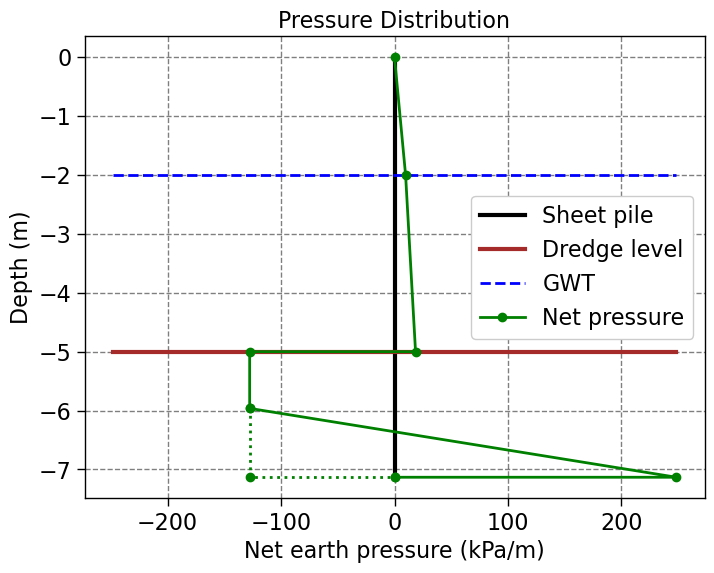

actual D = 3.2 m
Max moment = 103.65083928838925 kN-m/m
S = 0.000600874430657329 m3/m of the wall
None


In [39]:
properties = {
    'phi':32,
    'gamma_unsat': 15.9,
    'gamma_sat' : 19.33,
    'L1' : 2,
    'L2' : 3,
    'C' : 47, #cohesion in kPa
    'sigma_all' : 172.5 * 1e3
}

sheet_pile = SheetPileC(properties)

print(sheet_pile.max_moment_calc())